In [90]:
import numpy as np
import pandas as pd
import torch
import sys
import re

from sklearn.manifold import TSNE
import plotly.graph_objects as go

import argparse
import os
from os.path import dirname, abspath
from functools import partial
import json
import yaml
import numpy as np

import torch
import torch.nn as nn
from torchtext.data import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import DataLoader

import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR

from datasets import load_dataset

import seaborn as sns
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt

from torchtext.data import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import DataLoader

from datasets import Dataset
from tqdm.auto import tqdm

In [43]:
EMBED_DIMENSION = 300
EMBED_MAX_NORM = 1

data_dir = "/users/ujan/sports-language-in-politics/models/cbow/"

In [44]:
if torch.backends.mps.is_available(): device = "mps"
elif torch.cuda.is_available(): device = "cuda"
else: device = "cpu"

In [45]:
class CBOW_Model(nn.Module):
    """
    Implementation of CBOW model described in paper:
    https://arxiv.org/abs/1301.3781
    """

    def __init__(self, vocab_size: int):
        super(CBOW_Model, self).__init__()
        self.embeddings = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=EMBED_DIMENSION,
            max_norm=EMBED_MAX_NORM,
        )
        self.linear = nn.Linear(
            in_features=EMBED_DIMENSION,
            out_features=vocab_size,
        )

    def forward(self, inputs):
        x = self.embeddings(inputs)
        x = x.mean(axis=1)
        x = self.linear(x)
        return x

In [46]:
def get_embeddings_and_vocab(sub_name):
    
    vocab = torch.load(data_dir+sub_name+"_vocab.pt")
    print('vocab size: {}'.format(len(vocab.get_itos())))
    model = CBOW_Model(vocab_size=len(vocab.get_itos()))
    model = torch.load(data_dir+sub_name+"_model.pt", map_location=device)

    def normalization(embeddings):
        norms = (embeddings ** 2).sum(axis=1) ** (1 / 2)
        norms = np.reshape(norms, (len(norms), 1))
        embeddings_norm = embeddings / norms
        return embeddings_norm
    
    # embedding from first model layer
    embeddings = list(model.parameters())[0].cpu().detach().numpy()
    
    # normalization
    embeddings_norm = normalization(embeddings)

    return embeddings_norm, vocab


def get_top_similar(word: str, embeddings_norm, vocab, topN: int=5):
    word_id = vocab[word]
    if word_id == 0:
        print("Out of vocabulary word")
        return

    word_vec = embeddings_norm[word_id]
    word_vec = np.reshape(word_vec, (len(word_vec), 1))
    dists = np.matmul(embeddings_norm, word_vec).flatten()
    topN_ids = np.argsort(-dists)[1 : topN + 1]

    topN_dict = {}
    for sim_word_id in topN_ids:
        sim_word = vocab.lookup_token(sim_word_id)
        topN_dict[sim_word] = dists[sim_word_id]
    return topN_dict


def get_sim(word1: str, word2: str, embeddings_norm, vocab):
    if word1 not in vocab.get_itos() or word2 not in vocab.get_itos():
        print('not in vocab')
        return
    word1_id = vocab[word1]
    if word1_id == 0:
        print("Out of vocabulary word")
        return
    word2_id = vocab[word2]
    if word2_id == 0:
        print("Out of vocabulary word")
        return

    word1_vec = embeddings_norm[word1_id]
    #word1_vec = np.reshape(word1_vec, (len(word1_vec), 1))
    
    word2_vec = embeddings_norm[word2_id]
    #word2_vec = np.reshape(word2_vec, (len(word2_vec), 1))
    
    print(np.dot(word1_vec, word2_vec))

#### Comparisons

In [109]:
# with stop words, 100 epochs
embeddings_norm, vocab = get_embeddings_and_vocab('the_donald')
get_sim('trump', 'captain', embeddings_norm, vocab)
get_sim('biden', 'captain', embeddings_norm, vocab)
get_sim('trump', 'qb', embeddings_norm, vocab)  
get_sim('biden', 'qb', embeddings_norm, vocab)
get_sim('race', 'election', embeddings_norm, vocab)
get_sim('voters', 'fans', embeddings_norm, vocab)

vocab size: 5764
0.034618624
-0.040835813
-0.008040637
-0.022703318
-0.0040041488
-0.054104347


In [116]:
# without stop words, 100 epochs
embeddings_norm, vocab = get_embeddings_and_vocab('no_stop_the_donald')
get_sim('trump', 'captain', embeddings_norm, vocab)
get_sim('biden', 'captain', embeddings_norm, vocab)
get_sim('trump', 'qb', embeddings_norm, vocab)
get_sim('biden', 'qb', embeddings_norm, vocab)
get_sim('race', 'election', embeddings_norm, vocab)
get_sim('voters', 'fans', embeddings_norm, vocab)

vocab size: 5619
0.00909295
0.07778975
0.010088734
-0.026071038
0.07421315
0.07718981


In [65]:
# without stop words, 100 epochs, max_norm = 10
embeddings_norm, vocab = get_embeddings_and_vocab('no_stop_freq_20_the_donald')
get_sim('trump', 'captain', embeddings_norm, vocab)
get_sim('biden', 'captain', embeddings_norm, vocab)
get_sim('trump', 'qb', embeddings_norm, vocab)
get_sim('biden', 'qb', embeddings_norm, vocab)
get_sim('race', 'election', embeddings_norm, vocab)
get_sim('voters', 'fans', embeddings_norm, vocab)

vocab size: 10229
-0.05194399
0.047983184
-0.03879067
-0.1112338
0.050589863
0.10164413


In [118]:
# without stop words, 300 epochs
embeddings_norm, vocab = get_embeddings_and_vocab('no_stop_300_the_donald')
get_sim('trump', 'captain', embeddings_norm, vocab)
get_sim('biden', 'captain', embeddings_norm, vocab)
get_sim('trump', 'qb', embeddings_norm, vocab)
get_sim('biden', 'qb', embeddings_norm, vocab)
get_sim('race', 'election', embeddings_norm, vocab)
get_sim('voters', 'fans', embeddings_norm, vocab)

vocab size: 5606
0.03222485
0.03846648
-0.029520795
0.026687656
0.06016608
0.054330766


In [120]:
# without stop words, 100 epochs, max_norm = 10
embeddings_norm, vocab = get_embeddings_and_vocab('norm_10_the_donald')
get_sim('trump', 'captain', embeddings_norm, vocab)
get_sim('biden', 'captain', embeddings_norm, vocab)
get_sim('trump', 'qb', embeddings_norm, vocab)
get_sim('biden', 'qb', embeddings_norm, vocab)
get_sim('race', 'election', embeddings_norm, vocab)
get_sim('voters', 'fans', embeddings_norm, vocab)

vocab size: 5644
0.020659003
0.05348581
0.011043421
-0.024263585
0.12906256
-0.037614148


In [151]:
# without stop words, 100 epochs, max_norm = 10
embeddings_norm, vocab = get_embeddings_and_vocab('norm_100_the_donald')
get_sim('trump', 'captain', embeddings_norm, vocab)
get_sim('biden', 'captain', embeddings_norm, vocab)
get_sim('trump', 'qb', embeddings_norm, vocab)
get_sim('biden', 'qb', embeddings_norm, vocab)
get_sim('race', 'election', embeddings_norm, vocab)
get_sim('voters', 'fans', embeddings_norm, vocab)

vocab size: 5625
-0.035573043
0.009166977
0.027569694
0.015644236
0.11010522
-0.041369963


In [47]:
# without stop words, 100 epochs, max_norm = 10
embeddings_norm, vocab = get_embeddings_and_vocab('the_donald_20_context')
get_sim('trump', 'captain', embeddings_norm, vocab)
get_sim('biden', 'captain', embeddings_norm, vocab)
get_sim('trump', 'qb', embeddings_norm, vocab)
get_sim('biden', 'qb', embeddings_norm, vocab)
get_sim('race', 'election', embeddings_norm, vocab)
get_sim('voters', 'fans', embeddings_norm, vocab)

vocab size: 11229
-0.03848173
0.043416012
0.05009101
-0.012414329
0.13768494
0.058262315


In [59]:
# with stop words, 100 epochs
embeddings_norm, vocab = get_embeddings_and_vocab('politics')
get_sim('trump', 'captain', embeddings_norm, vocab)
get_sim('biden', 'captain', embeddings_norm, vocab) 
get_sim('trump', 'qb', embeddings_norm, vocab)
get_sim('biden', 'qb', embeddings_norm, vocab)
get_sim('race', 'election', embeddings_norm, vocab)  
get_sim('voters', 'fans', embeddings_norm, vocab)

vocab size: 6023
-0.015175674
0.04075729
-0.04098111
-0.032709993
-0.02134432
0.08296682


In [60]:
# without stop words, 100_epochs
embeddings_norm, vocab = get_embeddings_and_vocab('no_stop_politics')
get_sim('trump', 'captain', embeddings_norm, vocab)
get_sim('biden', 'captain', embeddings_norm, vocab)
get_sim('trump', 'qb', embeddings_norm, vocab)
get_sim('biden', 'qb', embeddings_norm, vocab)
get_sim('race', 'election', embeddings_norm, vocab)
get_sim('voters', 'fans', embeddings_norm, vocab)

vocab size: 5902
-0.053801555
-0.02035804
0.043366633
-0.082414515
0.051281035
0.03277685


In [48]:
# without stop words, 100_epochs, min word freq=20
embeddings_norm, vocab = get_embeddings_and_vocab('no_stop_freq_20_politics')
get_sim('trump', 'captain', embeddings_norm, vocab)
get_sim('biden', 'captain', embeddings_norm, vocab)
get_sim('trump', 'qb', embeddings_norm, vocab)
get_sim('biden', 'qb', embeddings_norm, vocab)
get_sim('race', 'election', embeddings_norm, vocab)
get_sim('voters', 'fans', embeddings_norm, vocab)

vocab size: 10589
-0.04870589
-0.046137027
0.012557586
-0.004711693
0.14320174
0.13246465


#### Plots

In [77]:
(0.08296682 + 0.03277685 + 0.13246465) / 3

0.08273610666666666

In [89]:
# the_donald, politics, different hyps, avg values

rep_dict = {
    'trump:captain': -0.0027441386666666664,
    'biden:captain': 0.02831237366666666,
    #'trump:qb': -0.012247524333333334,
    #'biden:qb': -0.053336052,
    'race:election': 0.04026628806666667,
    'voters:fans': 0.041576531,
}

dem_dict = {
    'trump:captain': -0.039227706333333334,
    'biden:captain': -0.008579258999999999,
    #'trump:qb': 0.0049810363333333335,
    #'biden:qb': -0.03994540033333333,
    'race:election': 0.05771281833333333,
    'voters:fans': 0.08273610666666666,
}

rep_df = pl.DataFrame(rep_dict)
dem_df = pl.DataFrame(dem_dict)

In [90]:
sns.set(rc={'figure.figsize':(9.7,7.27)})

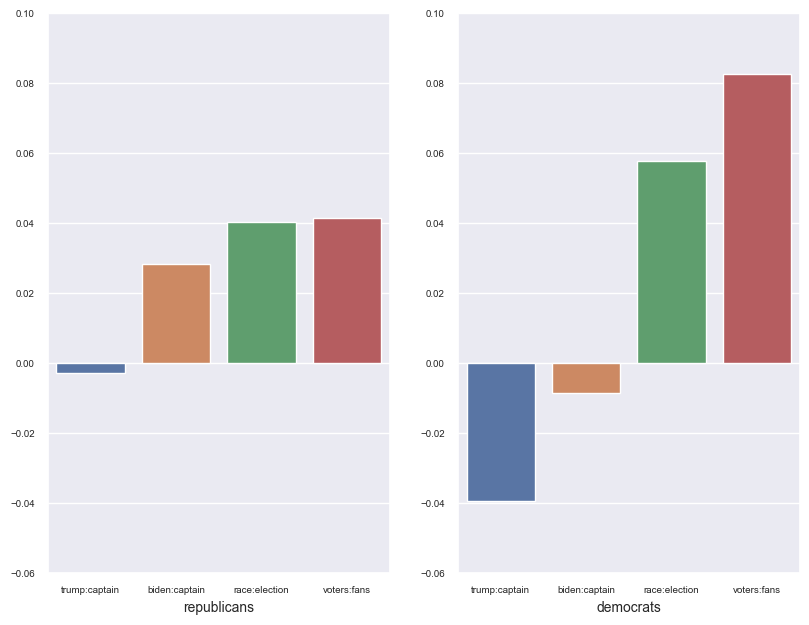

In [91]:
f, axes = plt.subplots(1, 2)
a = sns.barplot(data=rep_df.to_pandas(), orient='v' , ax=axes[0])
b = sns.barplot(data=dem_df.to_pandas(), orient='v' , ax=axes[1])

a.tick_params(labelsize=7)
b.tick_params(labelsize=7)

a.set_xlabel("republicans",fontsize=10)
b.set_xlabel("democrats",fontsize=10)

a.set(ylim=(-0.06, 0.1))
b.set(ylim=(-0.06, 0.1))

plt.show()

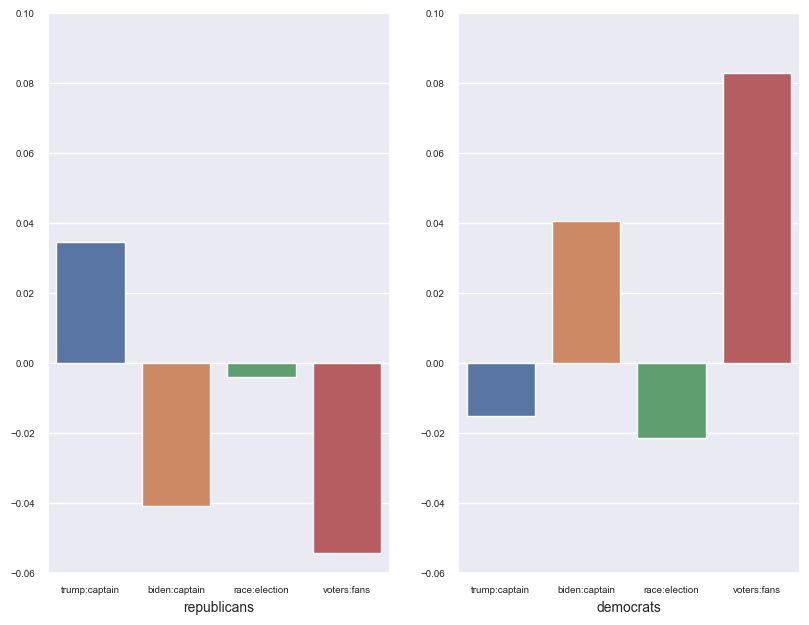

In [94]:
# the_donald, politics, 100 epochs, with stop words
rep_dict = {
    'trump:captain': 0.034618624,
    'biden:captain': -0.040835813,
    #'trump:qb': -0.008040637,
    #'biden:qb': -0.022703318,
    'race:election': -0.0040041488,
    'voters:fans': -0.054104347,
}

dem_dict = {
    'trump:captain': -0.015175674,
    'biden:captain': 0.04075729,
    #'trump:qb': -0.04098111,
    #'biden:qb': -0.032709993,
    'race:election': -0.02134432,
    'voters:fans': 0.08296682,
}

rep_df = pl.DataFrame(rep_dict)
dem_df = pl.DataFrame(dem_dict)

sns.set(rc={'figure.figsize':(9.7,7.27)})

f, axes = plt.subplots(1, 2)
a = sns.barplot(data=rep_df.to_pandas(), orient='v' , ax=axes[0])
b = sns.barplot(data=dem_df.to_pandas(), orient='v' , ax=axes[1])

a.tick_params(labelsize=7)
b.tick_params(labelsize=7)

a.set_xlabel("republicans",fontsize=10)
b.set_xlabel("democrats",fontsize=10)

a.set(ylim=(-0.06, 0.1))
b.set(ylim=(-0.06, 0.1))

plt.show()

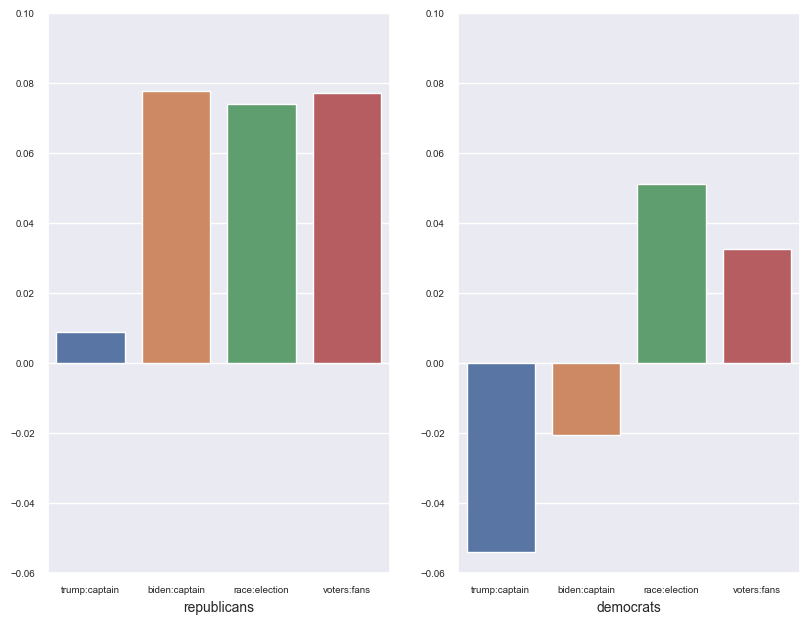

In [95]:
# the_donald, politics, 100 epochs, no stop words

rep_dict = {
    'trump:captain': 0.00909295,
    'biden:captain': 0.07778975,
    #'trump:qb': -0.008040637,
    #'biden:qb': -0.026071038,
    'race:election': 0.07421315,
    'voters:fans': 0.07718981,
}

dem_dict = {
    'trump:captain': -0.053801555,
    'biden:captain': -0.02035804,
    #'trump:qb': 0.043366633,
    #'biden:qb': -0.082414515,
    'race:election': 0.051281035,
    'voters:fans': 0.03277685,
}

rep_df = pl.DataFrame(rep_dict)
dem_df = pl.DataFrame(dem_dict)

sns.set(rc={'figure.figsize':(9.7,7.27)})

f, axes = plt.subplots(1, 2)
a = sns.barplot(data=rep_df.to_pandas(), orient='v' , ax=axes[0])
b = sns.barplot(data=dem_df.to_pandas(), orient='v' , ax=axes[1])

a.tick_params(labelsize=7)
b.tick_params(labelsize=7)

a.set_xlabel("republicans",fontsize=10)
b.set_xlabel("democrats",fontsize=10)

a.set(ylim=(-0.06, 0.1))
b.set(ylim=(-0.06, 0.1))

plt.show()

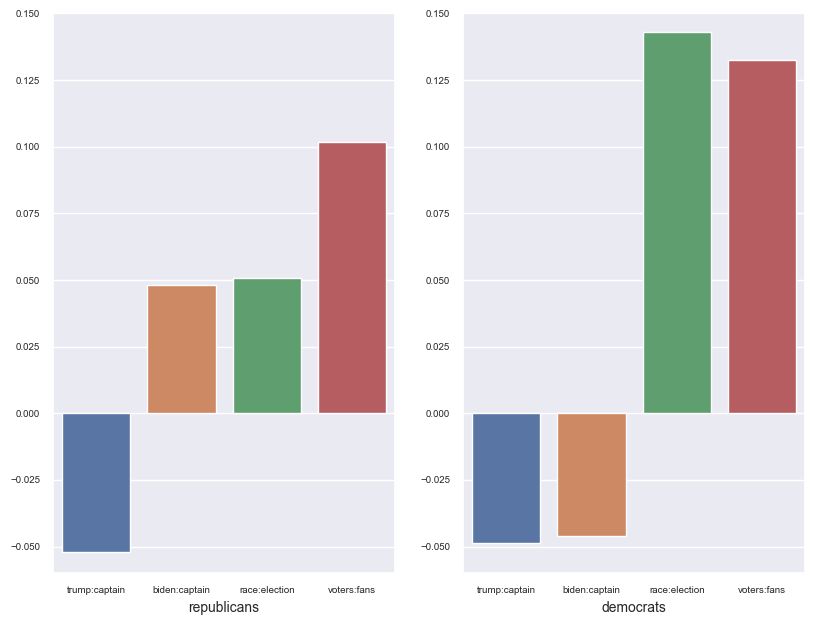

In [99]:
# the_donald, politics, 100 epochs, no stop words, min word freq=20

rep_dict = {
    'trump:captain': -0.05194399,
    'biden:captain': 0.047983184,
    #'trump:qb': -0.03879067,
    #'biden:qb': -0.1112338,
    'race:election': 0.050589863,
    'voters:fans': 0.10164413,
}

dem_dict = {
    'trump:captain': -0.04870589,
    'biden:captain': -0.046137027,
    #'trump:qb': 0.012557586,
    #'biden:qb': -0.004711693,
    'race:election': 0.14320174,
    'voters:fans': 0.13246465,
}

rep_df = pl.DataFrame(rep_dict)
dem_df = pl.DataFrame(dem_dict)

sns.set(rc={'figure.figsize':(9.7,7.27)})

f, axes = plt.subplots(1, 2)
a = sns.barplot(data=rep_df.to_pandas(), orient='v' , ax=axes[0])
b = sns.barplot(data=dem_df.to_pandas(), orient='v' , ax=axes[1])

a.tick_params(labelsize=7)
b.tick_params(labelsize=7)

a.set_xlabel("republicans",fontsize=10)
b.set_xlabel("democrats",fontsize=10)

a.set(ylim=(-0.06, 0.15))
b.set(ylim=(-0.06, 0.15))

plt.show()

In [92]:
# with stop words, 100 epochs
embeddings_norm, vocab = get_embeddings_and_vocab('politics')
get_sim('good', 'bad', embeddings_norm, vocab)
get_sim('red', 'blue', embeddings_norm, vocab) 

vocab size: 6023
0.48081937
0.2517801


In [93]:
# with stop words, 100 epochs
embeddings_norm, vocab = get_embeddings_and_vocab('the_donald')
get_sim('good', 'bad', embeddings_norm, vocab)
get_sim('red', 'blue', embeddings_norm, vocab) 

vocab size: 5764
0.3798148
0.26581362


#### Sim List (100 epochs, no stops)

sim values low

In [152]:
embeddings_norm, vocab = get_embeddings_and_vocab('no_stop_the_donald')
get_top_similar('bad', embeddings_norm, vocab)

vocab size: 5619


{'terrible': 0.23426071,
 'hurts': 0.22012997,
 'eli': 0.21621901,
 'horrible': 0.20877561,
 'suspicious': 0.20856634}

In [153]:
embeddings_norm, vocab = get_embeddings_and_vocab('norm_10_the_donald')
get_top_similar('bad', embeddings_norm, vocab)

vocab size: 5644


{'good': 0.40338245,
 'deciding': 0.1998555,
 'terrible': 0.1916355,
 'like': 0.17780505,
 'perfect': 0.16526628}

In [157]:
embeddings_norm, vocab = get_embeddings_and_vocab('norm_100_the_donald')
get_top_similar('bad', embeddings_norm, vocab)

vocab size: 5625


{'good': 0.38341334,
 'terrible': 0.20237805,
 'like': 0.19661625,
 'draw': 0.18660292,
 'camps': 0.18158375}

In [162]:
embeddings_norm, vocab = get_embeddings_and_vocab('context_10_the_donald')
get_top_similar('bad', embeddings_norm, vocab)

vocab size: 5618


{'good': 0.2318387,
 'blame': 0.17461991,
 'impression': 0.16470212,
 'ages': 0.16037121,
 'dozen': 0.15851797}

In [63]:
embeddings_norm, vocab = get_embeddings_and_vocab('no_stop_freq_20_the_donald')
get_top_similar('bad', embeddings_norm, vocab)

vocab size: 10229


{'terrible': 0.26770848,
 'horrible': 0.2333316,
 'shitty': 0.20905374,
 'important': 0.19857208,
 'slipped': 0.19481656}

In [49]:
embeddings_norm, vocab = get_embeddings_and_vocab('no_stop_freq_20_politics')
get_top_similar('bad', embeddings_norm, vocab)

vocab size: 10589


{'awful': 0.2574749,
 'good': 0.21907628,
 'horrible': 0.20221268,
 'terrible': 0.19803269,
 'shares': 0.19167534}

In [97]:
embeddings_norm, vocab = get_embeddings_and_vocab('no_stop_pos_politics') # freq 20
get_top_similar('bad', embeddings_norm, vocab)

vocab size: 10253


{'terrible': 0.24812376,
 'comfortable': 0.19659734,
 'dominant': 0.19462329,
 'poland': 0.19017859,
 'good': 0.18547519}

In [9]:
embeddings_norm, vocab = get_embeddings_and_vocab('the_donald_conservative') # freq 50
get_top_similar('bad', embeddings_norm, vocab)

vocab size: 12813


{'terrible': 0.36026692,
 'horrible': 0.3512573,
 'shitty': 0.28138334,
 'good': 0.25139344,
 'awful': 0.23673256}

In [12]:
embeddings_norm, vocab = get_embeddings_and_vocab('the_donald_conservative_no_unk') # freq 50
get_top_similar('bad', embeddings_norm, vocab)

vocab size: 12782


{'terrible': 0.39707363,
 'horrible': 0.35079277,
 'shitty': 0.27486697,
 'awful': 0.2426031,
 'punishing': 0.24043533}

In [105]:
embeddings_norm, vocab = get_embeddings_and_vocab('the_donald_20_context') # freq 50
get_top_similar('biden', embeddings_norm, vocab)

vocab size: 11229


{'joe': 0.3409217,
 'creepy': 0.30519742,
 'dealings': 0.29805443,
 'bidens': 0.29699478,
 'democrats': 0.26287612}

#### Wikitext (5 epochs)

In [102]:
embeddings_norm, vocab = get_embeddings_and_vocab('wiki')
#get_top_similar('blue', embeddings_norm, vocab)
#get_top_similar('king', embeddings_norm, vocab)
get_top_similar('good', embeddings_norm, vocab)
#get_top_similar('german', embeddings_norm, vocab)
#get_top_similar('bad', embeddings_norm, vocab)

vocab size: 4099


{'useful': 0.5289298,
 'better': 0.51288617,
 'difficult': 0.50605476,
 'whole': 0.48651743,
 'bad': 0.47341284}

#### POS

In [4]:
example = "The difference wasn’t 160. After the recount that the Green Party paid for they had found ~160 more votes for Trump. Trump won WI in 2016 by over 27k votes. And the reason for selecting 3% is because that is what would flip the state results from currently being for Biden to being for Trump in just the two countries being recounted. That shouldn’t be confusing. And there have been larger errors percentage-wise than that already in this election on county levels."

In [5]:
from flair.data import Sentence
from flair.models import SequenceTagger

# load tagger
tagger = SequenceTagger.load("flair/pos-english")

2024-02-06 17:58:21,391 SequenceTagger predicts: Dictionary with 53 tags: <unk>, O, UH, ,, VBD, PRP, VB, PRP$, NN, RB, ., DT, JJ, VBP, VBG, IN, CD, NNS, NNP, WRB, VBZ, WDT, CC, TO, MD, VBN, WP, :, RP, EX, JJR, FW, XX, HYPH, POS, RBR, JJS, PDT, NNPS, RBS, AFX, WP$, -LRB-, -RRB-, ``, '', LS, $, SYM, ADD


In [60]:
# make example sentence
example = """Side note about Netflix: I watched a Netflix original with my girlfriend. 
            Show was called Scandal, and it was alright, but you could see it was left leaning. 
            It was a political drama, and season 5 literally mimics this election from a SJW perspective. 
            There were 3 candidates (as opposed to 2), one of which was characterized by the media 
            as a 'racist, sexist, hate speech spewing bigot' but yet despite these titles, 
            his popularity continued to grow. Then there's a segment about how saying 'All Lives Matter' 
            is offensive to BLM. They literally said this shit in the show. 
            I have it a 1-star rating and cancelled my Netflix membership. I'll just pirate shit from now on."""

#example = example.lower()

sentence = Sentence(example)

# predict NER tags
tagger.predict(sentence)

# print sentence
#print(sentence)

# print predicted NER spans
#print('The following NER tags are found:')
# iterate over entities and print
#for entity in sentence.get_spans('pos'):
    #print(entity)

In [62]:
sent = []
for token in sentence:
    if token.tag != 'NNP':
        sent.append(token.form)

' '.join(sent)

"Side note about : I watched a original with my girlfriend . was called , and it was alright , but you could see it was left leaning . It was a political drama , and season 5 literally mimics this election from a perspective . There were 3 candidates ( as opposed to 2 ) , one of which was characterized by the media as a ' racist , sexist , hate speech spewing bigot ' but yet despite these titles , his popularity continued to grow . Then there 's a segment about how saying ' All Lives ' is offensive to . They literally said this shit in the show . I have it a 1-star rating and cancelled my membership . I 'll just pirate shit from now on ."

#### Analysis

In [94]:
MAX_SEQUENCE_LENGTH = 256
MIN_WORD_FREQUENCY = 50  # 50 for wikitext, 20 for The_Donald

In [95]:
def yield_tokens(dataset, tokenizer):
    for text in dataset['text']:
        yield tokenizer(text)

def get_dataloader_and_vocab(dataset, ds_type, batch_size, tokenizer, vocab):

    dataset = dataset[ds_type]

    if vocab is None:
        vocab = build_vocab_from_iterator(
            yield_tokens(dataset, tokenizer),
            specials=["<unk>"],
            min_freq=MIN_WORD_FREQUENCY
        )
        vocab.set_default_index(vocab["<unk>"])

    def text_pipeline(x): return vocab(tokenizer(x))

    dataloader = DataLoader(
        dataset['text'],
        batch_size=batch_size,
        #shuffle=shuffle,
        collate_fn=partial(collate_cbow, text_pipeline=text_pipeline),
    )

    return dataloader, vocab

def collate_cbow(batch, text_pipeline):
    batch_input, batch_output = [], []

    for text in batch:
        text_tokens_ids = text_pipeline(text)

        if len(text_tokens_ids) < CBOW_N_WORDS * 2 + 1:
            continue

        if MAX_SEQUENCE_LENGTH:
            text_tokens_ids = text_tokens_ids[:MAX_SEQUENCE_LENGTH]

        for idx in range(len(text_tokens_ids) - CBOW_N_WORDS * 2):
            token_id_sequence = text_tokens_ids[idx: (
                idx + CBOW_N_WORDS * 2 + 1)]
            output = token_id_sequence.pop(CBOW_N_WORDS)
            input_ = token_id_sequence
            batch_input.append(input_)
            batch_output.append(output)

    batch_input = torch.tensor(batch_input, dtype=torch.long)
    batch_output = torch.tensor(batch_output, dtype=torch.long)
    return batch_input, batch_output

##### wikitext

In [96]:
dataset = load_dataset('wikitext', 'wikitext-2-v1')
tokenizer = get_tokenizer("basic_english", language="en")

word_count = 0
for text in dataset['train']['text']:
    if text != '':
        word_count += len(text.split())

print('word count : {}'.format(word_count))

train_dataloader, vocab = get_dataloader_and_vocab(
    dataset=dataset,
    ds_type="train",
    batch_size=96,
    tokenizer=tokenizer,
    vocab=None,
)

vocab_size = len(vocab.get_stoi())
print(f"Vocabulary size: {vocab_size}")

print('total_words : vocab = {}'.format(word_count//vocab_size))

word count : 2051910
Vocabulary size: 4099
total_words : vocab = 500


In [97]:
freqs = {}
stoi_dict = vocab.get_stoi()
bar = tqdm(range(len(dataset['train']['text'])))
for text in dataset['train']['text']:
    if text != '':
        for word in text.split():
            if word in stoi_dict:
                if word in freqs:
                    freqs[word] += 1
                else:
                    freqs[word] = 1
    bar.update(1)

  0%|          | 0/36718 [00:00<?, ?it/s]

In [98]:
sorted_freqs = dict(sorted(freqs.items(), key=lambda item: item[1], reverse=True))

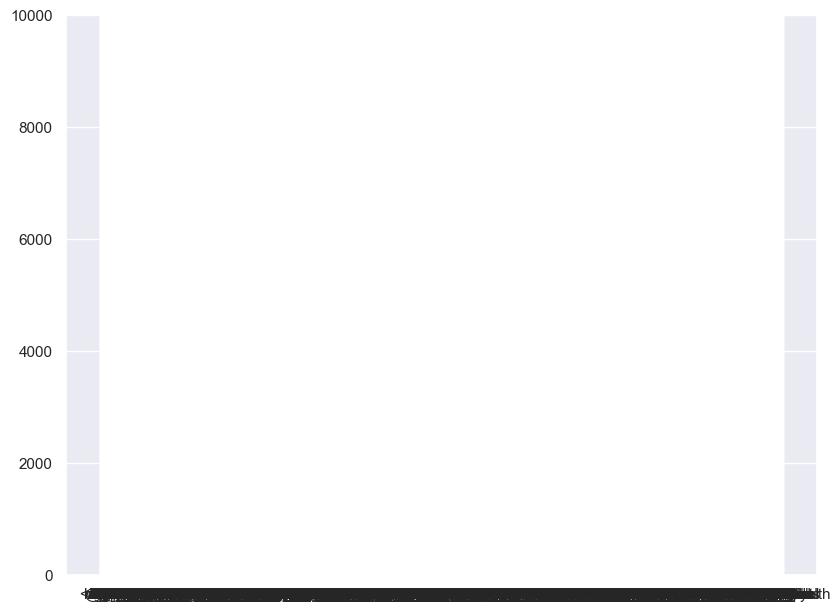

In [99]:
#sns.set(rc={'figure.figsize':(9.7,7.27)})
plt.ylim(0, 10000)
plt.bar(sorted_freqs.keys(), sorted_freqs.values(), color='g')
plt.show()

In [84]:
sorted_freqs

{'the': 113161,
 ',': 99913,
 '.': 73388,
 'of': 56889,
 '<unk>': 54625,
 'and': 50603,
 'in': 39453,
 'to': 39190,
 'a': 34237,
 '=': 29570,
 'was': 20985,
 '@-@': 16906,
 'that': 14135,
 'as': 14021,
 'on': 13678,
 'for': 13307,
 'with': 12606,
 'by': 12148,
 ')': 12004,
 '(': 11992,
 'is': 11637,
 'from': 8941,
 'his': 8395,
 'at': 8186,
 'were': 7330,
 'it': 6748,
 'he': 5947,
 'an': 5895,
 'had': 5698,
 'which': 5543,
 'be': 4787,
 'are': 4669,
 'their': 4127,
 'but': 4035,
 'first': 3978,
 '–': 3934,
 'not': 3906,
 'also': 3746,
 'its': 3697,
 'or': 3636,
 'her': 3486,
 'have': 3442,
 'one': 3351,
 'has': 3322,
 'been': 3257,
 'two': 3238,
 'this': 3079,
 'who': 2963,
 'they': 2941,
 "'": 2870,
 'after': 2640,
 'time': 2451,
 'into': 2440,
 'other': 2433,
 'would': 2320,
 'more': 2319,
 '1': 2253,
 'all': 2100,
 'when': 2036,
 'over': 2015,
 '2': 1982,
 'she': 1981,
 'during': 1973,
 'only': 1948,
 'game': 1846,
 'up': 1843,
 'him': 1840,
 'about': 1833,
 'three': 1803,
 'most': 

##### comments

In [62]:
subs = ['The_Donald']
seed = 42
min_comment_length = 100

In [27]:
politics_df = pl.read_csv('/users/ujan/sports-language-in-politics/data/processed/politics_sample.csv').drop_nulls()
sports_df = pl.read_csv('/users/ujan/sports-language-in-politics/data/processed/sports_sample.csv').drop_nulls()

In [63]:
# filter out subs
data_df = politics_df.filter(pl.col('subreddit').is_in(subs))
# shuffle dataframe
data_df = data_df.sample(fraction=1.0, shuffle=True, seed=seed)

# get sports sample of same length after shuffle
sports_df = sports_df.sample(fraction=1.0, shuffle=True, seed=seed)[:len(data_df)]

# concat dfs and shuffle again
data_df = pl.concat([data_df, sports_df]).sample(fraction=1.0, shuffle=True, seed=seed)

# filter comments
print('filtering comments')
comments = [comment.replace("'", '')
            for comment in data_df['body'].to_list()]
comments = [re.sub(r"[^a-zA-Z0-9]+", ' ', comment).lower()
            for comment in comments]

comments_long = []
# filter by char
for c in range(len(comments)):
    if len(comments[c]) >= min_comment_length:
        comments_long.append(comments[c])

filtering comments


In [88]:
sample_size = 100000

In [89]:
comments = comments_long[:sample_size]
#comments = comments_long

print('total comments : {}'.format(len(comments)))
word_count = 0
for comment in comments:
    word_count += len(comment.split())
print('total words : {}'.format(word_count))

data_dict = {"text": comments}
dataset = Dataset.from_dict(data_dict).train_test_split(test_size=0.1)

tokenizer = get_tokenizer("basic_english", language="en")

train_dataloader, vocab = get_dataloader_and_vocab(
    dataset=dataset,
    ds_type="train",
    batch_size=96,
    tokenizer=tokenizer,
    vocab=None,
)

vocab_size = len(vocab.get_stoi())
print(f"Vocabulary size: {vocab_size}")

print('total_words : vocab = {}'.format(word_count//vocab_size))

total comments : 100000
total words : 4907529
Vocabulary size: 10396
total_words : vocab = 472


In [91]:
freqs = {}
stoi_dict = vocab.get_stoi()
bar = tqdm(range(len(comments)))
for text in comments:
    if text != '':
        for word in text.split():
            if word in stoi_dict:
                if word in freqs:
                    freqs[word] += 1
                else:
                    freqs[word] = 1
    bar.update(1)

  0%|          | 0/100000 [00:00<?, ?it/s]

In [92]:
sorted_freqs = dict(sorted(freqs.items(), key=lambda item: item[1], reverse=True))

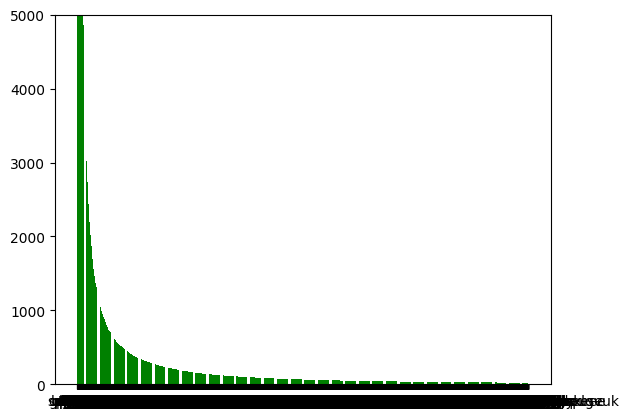

In [74]:
#sns.set(rc={'figure.figsize':(9.7,7.27)})

#a.tick_params(labelsize=7)
#b.tick_params(labelsize=7)

#a.set_xlabel("republicans",fontsize=10)
#b.set_xlabel("democrats",fontsize=10)
plt.ylim(0, 10000)
plt.bar(sorted_freqs.keys(), sorted_freqs.values(), color='g')
#ax.tick_params(labelsize=7)
#ax.set(ylim=(0, 5000))
plt.show()

In [93]:
sorted_freqs

{'the': 211178,
 'to': 125448,
 'a': 113289,
 'and': 108474,
 'of': 81275,
 'i': 75817,
 'is': 70123,
 'in': 65133,
 'that': 65060,
 'it': 53993,
 'for': 45065,
 'you': 42266,
 'he': 39389,
 'they': 37485,
 'this': 35899,
 'but': 34246,
 'on': 34218,
 'be': 33824,
 'was': 31738,
 'have': 30267,
 'are': 30076,
 'with': 29900,
 'not': 29659,
 'if': 28619,
 'we': 24334,
 'as': 24049,
 'just': 21674,
 'like': 21507,
 'at': 19825,
 'so': 19656,
 'all': 19649,
 'his': 18792,
 'its': 18673,
 'or': 18194,
 'would': 16050,
 'about': 15928,
 'people': 15825,
 'what': 15675,
 'can': 15375,
 'their': 15136,
 'him': 14848,
 'from': 14658,
 'up': 14616,
 'out': 14590,
 'has': 14254,
 'get': 14119,
 'one': 13833,
 'will': 13791,
 'think': 13701,
 'dont': 13408,
 'more': 13133,
 'an': 13114,
 'when': 13042,
 'no': 13028,
 'do': 12926,
 'my': 12779,
 'who': 12755,
 'them': 12628,
 'there': 12448,
 'because': 12111,
 'by': 11510,
 'how': 11367,
 'were': 11059,
 's': 10840,
 'your': 10329,
 'trump': 1023

In [3]:
the_donald_vocab = torch.load("/users/ujan/sports-language-in-politics/models/cbow/the_donald_vocab.pt")
#politics_vocab = torch.load(f"/users/ujan/sports-language-in-politics/models/cbow/politics_vocab.pt")

In [28]:
print(len(the_donald_vocab.get_itos()))
print(len(politics_vocab.get_itos()))

5764
6023


In [30]:
the_donald_model = CBOW_Model(vocab_size=len(the_donald_vocab.get_itos()))
politics_model = CBOW_Model(vocab_size=len(politics_vocab.get_itos()))

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

the_donald_model = torch.load(f"/users/ujan/sports-language-in-politics/models/cbow/the_donald_model.pt", map_location=device)
politics_model = torch.load(f"/users/ujan/sports-language-in-politics/models/cbow/politics_model.pt", map_location=device)

In [32]:
def normalization(embeddings):
    norms = (embeddings ** 2).sum(axis=1) ** (1 / 2)
    norms = np.reshape(norms, (len(norms), 1))
    embeddings_norm = embeddings / norms
    return embeddings_norm

# embedding from first model layer
the_donald_embeddings = list(the_donald_model.parameters())[0].cpu().detach().numpy()
politics_embeddings = list(politics_model.parameters())[0].cpu().detach().numpy()

# normalization
the_donald_embeddings_norm = normalization(the_donald_embeddings)
politics_embeddings_norm = normalization(politics_embeddings)

#embeddings_norm.shape

In [96]:
# get embeddings
#embeddings_df = pd.DataFrame(embeddings)
#embeddings_df.index = vocab.get_itos()
#embeddings_df.head()

In [97]:
# t-SNE transform
#tsne = TSNE(n_components=2)
#embeddings_df_trans = tsne.fit_transform(embeddings_df)
#embeddings_df_trans = pd.DataFrame(embeddings_df_trans)

# get token order
#embeddings_df_trans.index = vocab.get_itos()

In [98]:
#embeddings_df_trans = embeddings_df_trans.filter(items=imp_tokens, axis=0)
#is_imp = np.array([True if item in imp_tokens else False for item in embeddings_df_trans.index.to_list()])

In [48]:
get_sim('trump', 'coach', the_donald_embeddings_norm, the_donald_vocab)

-0.04026563


In [49]:
get_sim('trump', 'coach', politics_embeddings_norm, politics_vocab)

-0.05653703


In [50]:
get_sim('biden', 'coach', the_donald_embeddings_norm, the_donald_vocab)

0.04188435


In [51]:
get_sim('biden', 'coach', politics_embeddings_norm, politics_vocab)

-0.04346505


In [52]:
get_sim('trump', 'captain', the_donald_embeddings_norm, the_donald_vocab)

0.0028022937


In [53]:
get_sim('trump', 'captain', politics_embeddings_norm, politics_vocab)

-0.03859412


In [54]:
get_sim('biden', 'captain', the_donald_embeddings_norm, the_donald_vocab)

-0.01190008


In [55]:
get_sim('biden', 'captain', politics_embeddings_norm, politics_vocab)

-0.026512047


In [56]:
get_sim('team', 'party', the_donald_embeddings_norm, the_donald_vocab)

0.04290112


In [58]:
get_sim('team', 'party', politics_embeddings_norm, politics_vocab)

0.09244258


In [59]:
get_sim('race', 'election', the_donald_embeddings_norm, the_donald_vocab)

0.17911956


In [61]:
get_sim('race', 'election', politics_embeddings_norm, politics_vocab)

0.1729147


In [62]:
get_sim('voter', 'fan', the_donald_embeddings_norm, the_donald_vocab)

0.1029864


In [63]:
get_sim('voter', 'fan', politics_embeddings_norm, politics_vocab)

0.14804637


In [207]:
# Conservative

In [208]:
get_sim('trump', 'coach')

0.025071468


In [209]:
get_sim('biden', 'coach')

-0.10821757


In [210]:
get_sim('race', 'election')

0.12638268


In [211]:
get_sim('voter', 'fan')

0.114419945


In [ ]:
# The_Donald

In [103]:
get_sim('trump', 'coach')

-0.06472175


In [104]:
get_sim('biden', 'coach')

-0.06473538


In [105]:
get_sim('race', 'election')

0.11673814


In [106]:
get_sim('voter', 'fan')

0.12745565


In [ ]:
# AskTrumpSupporters

In [82]:
get_sim('trump', 'coach')

0.052884884


In [83]:
get_sim('biden', 'coach')

0.013537772


In [84]:
get_sim('race', 'election')

0.13959454


In [85]:
get_sim('voter', 'fan')

0.0014483271


In [ ]:
# democrats

In [189]:
get_sim('trump', 'coach')

0.17658761


In [190]:
get_sim('biden', 'coach')

0.020108037


In [191]:
get_sim('race', 'election')

0.42546162


In [192]:
get_sim('voter', 'fan')

0.17199346


In [ ]:
# socialism

In [18]:
#get_sim('trump', 'coach')

0.14144689


In [19]:
#get_sim('biden', 'coach')

0.062172484


In [20]:
#get_sim('race', 'election')

0.073596984


In [ ]:
# JoeBiden

In [37]:
get_sim('trump', 'coach')

0.09293979


In [38]:
get_sim('biden', 'coach')

-0.0011312668


In [39]:
get_sim('race', 'election')

0.2310926


In [40]:
get_sim('voter', 'fan')

0.14530016


In [ ]:
# AskALiberal

In [62]:
get_sim('trump', 'coach')

0.19343403


In [63]:
get_sim('biden', 'coach')

0.013923576


In [64]:
get_sim('race', 'election')

0.11042511


In [65]:
get_sim('voter', 'fan')

-0.02277404


In [1]:
import polars as pl
import re

In [2]:
df = pl.read_csv('/users/ujan/sports-language-in-politics/data/processed/politics_sample.csv').drop_nulls()

In [4]:
df = pl.read_csv('/users/ujan/sports-language-in-politics/data/processed/sports_sample.csv').drop_nulls()

In [5]:
len(df)

4306780

In [ ]:
df['subreddit'].unique().to_list()

In [11]:
len(df.filter(pl.col('subreddit') == 'Conservative'))

86348

In [20]:
len(df.filter(pl.col('subreddit') == 'Donald_Trump'))

184

In [22]:
len(df.filter(pl.col('subreddit') == 'donaldtrump'))

1147

In [23]:
len(df.filter(pl.col('subreddit') == 'AskTrumpSupporters'))

28454

In [24]:
len(df.filter(pl.col('subreddit') == 'The_Donald'))

419292

In [6]:
419292 + 86348

505640

In [21]:
len(df.filter(pl.col('subreddit') == 'JoeBiden'))

7632

In [16]:
#len(df.filter(pl.col('subreddit') == 'AskALiberal'))

12888

In [17]:
len(df.filter(pl.col('subreddit') == 'democrats'))  # 238 biden, 1063 trump (> 50 chars)

6308

In [18]:
#len(df.filter(pl.col('subreddit') == 'socialism'))

14020

In [5]:
len(df.filter(pl.col('subreddit') == 'Liberal'))

2142

In [6]:
len(df.filter(pl.col('subreddit') == 'politics'))

1249375

In [7]:
len(df.filter(pl.col('subreddit') == 'obama'))

164

In [8]:
len(df.filter(pl.col('subreddit') == 'esist'))

6913

In [9]:
len(df.filter(pl.col('subreddit') == 'progressive'))

1860

In [ ]:
# liberal, politics, obama, bernie, sandersforpresident, r/esist, progressive

In [ ]:
# politics sub

In [10]:
sports_df = pl.read_csv('/users/ujan/sports-language-in-politics/data/processed/sports_sample.csv').drop_nulls()

In [ ]:
sports_df['subreddit'].unique().to_list()

In [17]:
comments = [comment.replace("'", '')for comment in sports_df['body'].to_list()]
comments = [re.sub(r"[^a-zA-Z0-9]+", ' ', comment).lower() for comment in comments]

In [18]:
comments[13]

'i think everyone can agree that an exciting 3 3 tie would be fantastic'

In [19]:
len(comments)

4306780

In [24]:
count = 0
for comment in comments:
    if 'qbf' in comment:
        count += 1

count

45578

In [42]:
import seaborn as sns
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt

In [13]:
(0.17199346 + 0.14530016 + -0.02277404) / 3

0.09817319333333334

In [22]:
# Conservative, The_Donald, AskTrumpSupporters
rep_dict = {
    'trump:coach': 0.004411534000000002,
    'biden:coach': -0.053138392666666666,
    'race:election': 0.12757178666666666,
    'voter:fan': 0.08110797403333334,
}

# democrats, JoeBiden, AskALiberal
dem_dict = {
    'trump:coach': 0.15432047666666668,
    'biden:coach': 0.010966782066666667,
    'race:election': 0.25565977666666667,
    'voter:fan': 0.09817319333333334,
}

rep_df = pl.DataFrame(rep_dict)
dem_df = pl.DataFrame(dem_dict)

In [45]:
sns.set(rc={'figure.figsize':(9.7,7.27)})

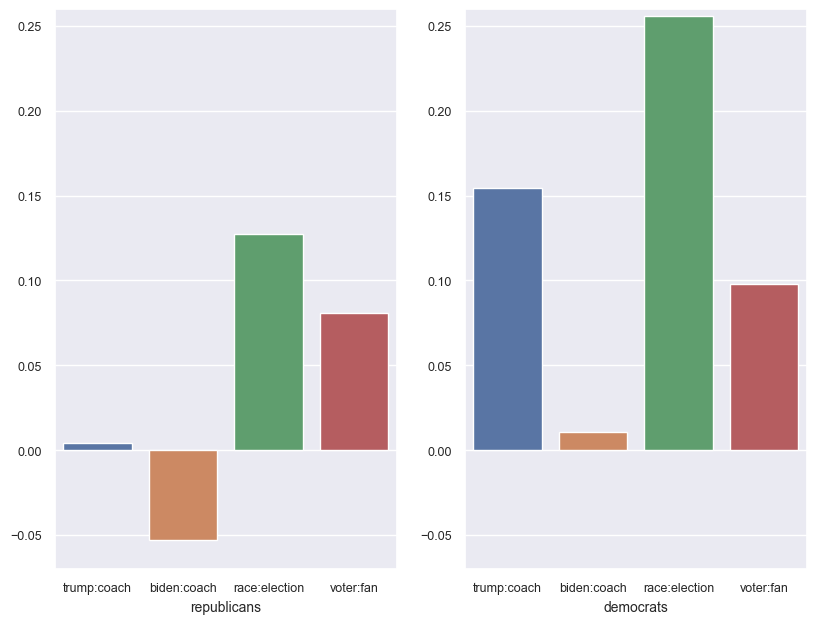

In [49]:
f, axes = plt.subplots(1, 2)
a = sns.barplot(data=rep_df.to_pandas(), orient='v' , ax=axes[0])
b = sns.barplot(data=dem_df.to_pandas(), orient='v' , ax=axes[1])

a.tick_params(labelsize=9)
b.tick_params(labelsize=9)

a.set_xlabel("republicans",fontsize=10)
b.set_xlabel("democrats",fontsize=10)

a.set(ylim=(-0.07, 0.260))
b.set(ylim=(-0.07, 0.260))

plt.show()

In [ ]:
# verify trend with random mappings